# Priority 指标

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os
import matplotlib.pyplot as plt

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

间接用水比例（Indirect Proportion of Water Use）来指示供水优先性，用于描述被消耗的水资源中，以间接形式惠益于人类的部分。

计算方法：
$$ I_{P} = \frac{WU_{non-pro}}{WU_{pro} + WU_{non-pro}} $$

其中i是年份，indirect和direct分别是为人类间接带来惠益的取用水方式和带来直接惠益取用水方式

indirect包括： 
- 工业用水量（IND），每年用于工业目的的取水量，包括自给自足的工业和与公共供水网络连接的工业。
- 城市服务业用水量（Urban service WU），指公共供水网络每年用于服务活动的直接用水量。

direct包括：
- 农业灌溉用水总量（IRR）：每年抽取的灌溉用水量，包括运输和田间施用期间的损失，但不包括牧场或水产养殖用水
- 城市居民用水（Urban domestic WU）：公共供水网络每年用于城镇居民直接取水的水量
- 农村居民用水（Rural domestic WU）：公共供水网络每年用于农村居民和牲畜直接使用的取水量
- 农村牲畜用水（Rural livestock WU）：公共供水网络用于牲畜饮水和清洁的年度取水量

In [2]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(cfg.db.perfectures)

## 指标计算

In [3]:
from regimes_yrb.priority import direct_ratio

# 产生直接惠益的用水方式
direct = [
    "IRR",
    "Urban domestic WU",
    "Rural domestic WU",
    "Rural livestock WU",
]

# 产生间接惠益的用水方式
indirect = ["IND", "Urban service WU"]

# 数据是用水量，每年加总
data = city_yr.groupby("Year").sum(numeric_only=True)

# 计算比例
priority, priority_contributions = direct_ratio(data, indirect=indirect, direct=direct)

# 数据导出
priority.to_csv(cfg.db.results.P)
priority_contributions.to_csv(cfg.db.contribution.P)

### 各部分贡献

In [4]:
priority_contributions

,P1: 1965-1977,P2: 1978-1988,P3: 1989-2002,P4: 2003-2013
Total,0.004457,-0.013695,-0.014570,-0.021521
Numerator,0.483941,0.039635,0.083232,0.045613
Denominator,-0.479484,-0.053329,-0.097801,-0.067133
IRR,0.450185,0.036622,0.074549,0.038187
Urban domestic WU,0.010347,0.001044,0.003740,0.004030
Rural domestic WU,0.018632,0.001567,0.003608,0.002367
Rural livestock WU,0.004778,0.000401,0.001335,0.001029


### 按照当前断点作图

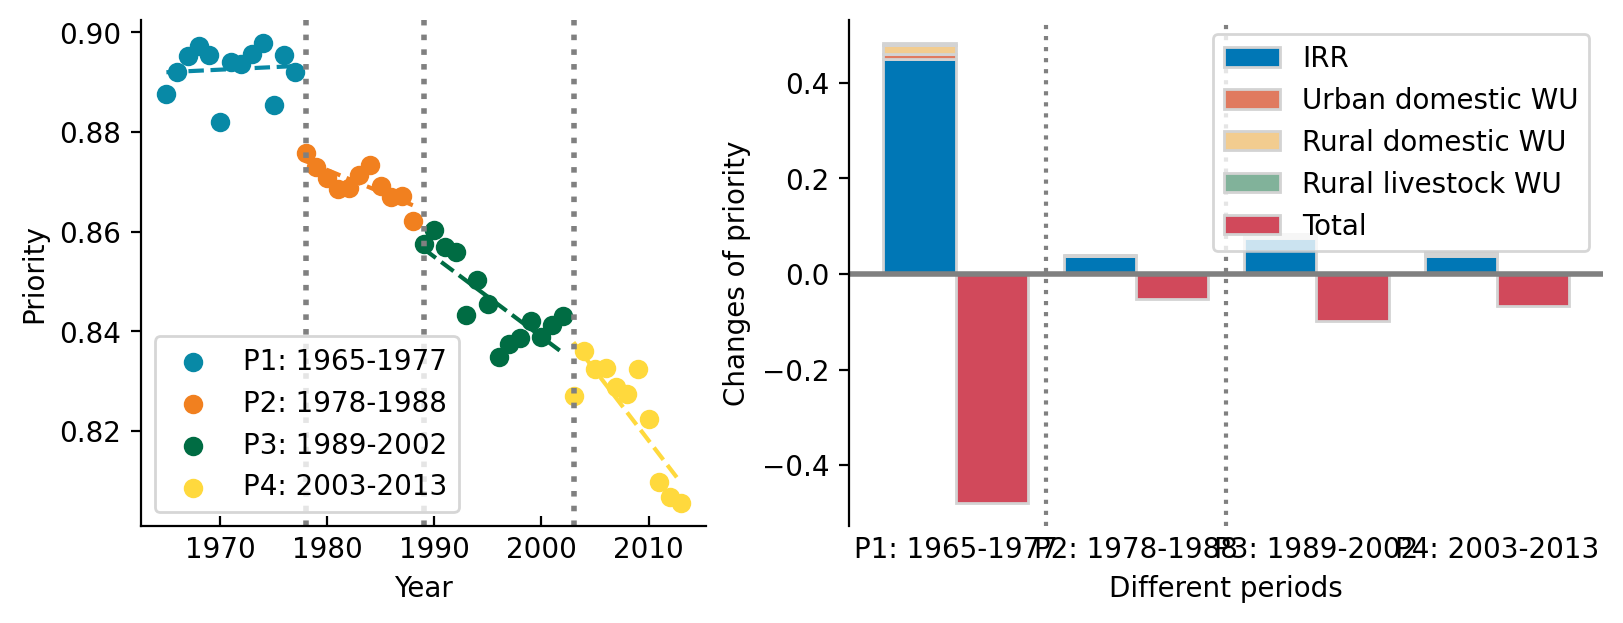

In [5]:
from regimes_yrb.plot import plot_data

ax1, ax2 = plot_data(
    priority,
    priority_contributions,
    "Priority",
    "Changes of priority",
    "Total",
)

### 按照项目断点进行划分

In [6]:
cfg.breakpoints

[1978, 2001]

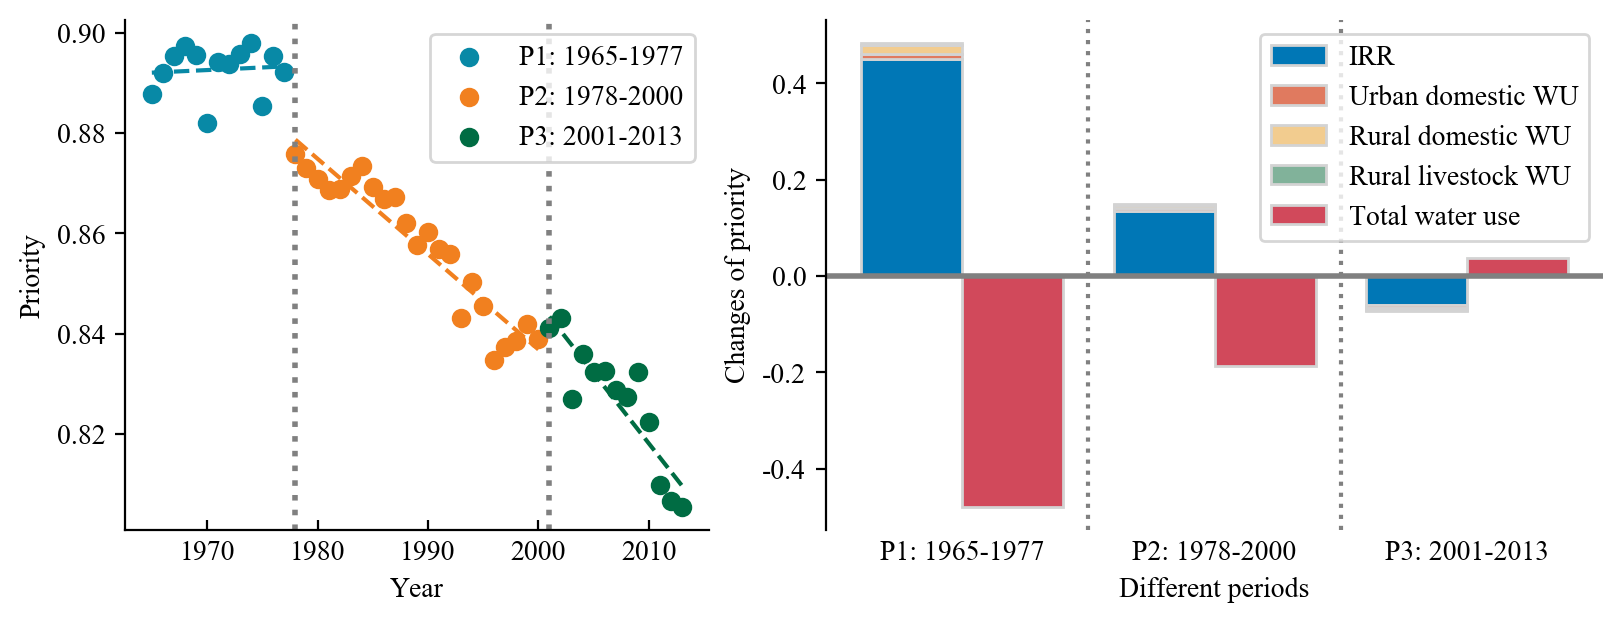

In [8]:
from mksci_font import config_font, update_font


config_font()
priority, priority_contributions = direct_ratio(
    data, indirect=indirect, direct=direct, breakpoints=cfg.breakpoints
)

ax1, ax2 = plot_data(
    priority,
    priority_contributions,
    "Priority",
    "Changes of priority",
    "Total water use",
    change_points=cfg.breakpoints,
)
# update_font(ax1, xlabel="年份", ylabel="使用目的")
# update_font(ax2, xlabel="时段", ylabel="贡献比例")
plt.savefig("figures/sup/priority.jpg", dpi=300)

In [ ]:
mapping = {
    "Total": "总用水",
    "IRR": "灌溉用水",
    "Urban domestic WU": "城市人居用水",
    "Rural domestic WU": "农村人居用水",
    "Rural livestock WU": "农村牲畜用水",
}
priority_contributions.rename(mapping, axis=0)